## This is the softmax workbook for ECE C147/C247 Assignment #2

Please follow the notebook linearly to implement a softmax classifier.

Please print out the workbook entirely when completed.

We thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  These are the functions in the cs231n folders and code in the jupyer notebook to preprocess and show the images.  The classifiers used are based off of code prepared for CS 231n as well.

The goal of this workbook is to give you experience with training a softmax classifier.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cifar-10-batches-py' # You need to update this line
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Training a softmax classifier.

The following cells will take you through building a softmax classifier.  You will implement its loss function, then subsequently train it with gradient descent.  Finally, you will choose the learning rate of gradient descent to optimize its classification performance.

In [3]:
from nndl import Softmax

In [4]:
# Declare an instance of the Softmax class.  
# Weights are initialized to a random value.
# Note, to keep people's first solutions consistent, we are going to use a random seed.

np.random.seed(1)

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

softmax = Softmax(dims=[num_classes, num_features])

#### Softmax loss

In [5]:
## Implement the loss function of the softmax using a for loop over
#  the number of examples

loss = softmax.loss(X_train, y_train)

In [6]:
print(loss)

2.327760702804897


## Question: 

You'll notice the loss returned by the softmax is about 2.3 (if implemented correctly).  Why does this make sense?

## Answer:

Initially, the model was not trained so if we randomly pick a class, the probability of it being the correct class is around $1/10$, so the loss is $\log(1/10)\approx 2.3$

#### Softmax gradient

In [7]:
## Calculate the gradient of the softmax loss in the Softmax class.
# For convenience, we'll write one function that computes the loss
#   and gradient together, softmax.loss_and_grad(X, y)
# You may copy and paste your loss code from softmax.loss() here, and then
#   use the appropriate intermediate values to calculate the gradient.

loss, grad = softmax.loss_and_grad(X_dev,y_dev)

# Compare your gradient to a gradient check we wrote. 
# You should see relative gradient errors on the order of 1e-07 or less if you implemented the gradient correctly.
softmax.grad_check_sparse(X_dev, y_dev, grad)

numerical: -0.268932 analytic: -0.268932, relative error: 3.007670e-08
numerical: 0.366764 analytic: 0.366764, relative error: 1.088382e-07
numerical: 0.281536 analytic: 0.281536, relative error: 3.765738e-08
numerical: 1.614423 analytic: 1.614423, relative error: 1.993564e-08
numerical: 0.366439 analytic: 0.366439, relative error: 1.934526e-07
numerical: 1.232479 analytic: 1.232479, relative error: 3.636539e-08
numerical: -0.412350 analytic: -0.412350, relative error: 8.985953e-08
numerical: -0.770490 analytic: -0.770490, relative error: 3.883353e-08
numerical: 0.757048 analytic: 0.757048, relative error: 2.677924e-09
numerical: -2.042153 analytic: -2.042153, relative error: 3.406580e-08


## A vectorized version of Softmax

To speed things up, we will vectorize the loss and gradient calculations.  This will be helpful for stochastic gradient descent.

In [8]:
import time

In [9]:
## Implement softmax.fast_loss_and_grad which calculates the loss and gradient
#    WITHOUT using any for loops.  

# Standard loss and gradient
tic = time.time()
loss, grad = softmax.loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Normal loss / grad_norm: {} / {} computed in {}s'.format(loss, np.linalg.norm(grad, 'fro'), toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax.fast_loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Vectorized loss / grad: {} / {} computed in {}s'.format(loss_vectorized, np.linalg.norm(grad_vectorized, 'fro'), toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference in loss / grad: {} /{} '.format(loss - loss_vectorized, np.linalg.norm(grad - grad_vectorized)))

# You should notice a speedup with the same output.

Normal loss / grad_norm: 2.3091567316108104 / 319.0460450714532 computed in 0.07800030708312988s
Vectorized loss / grad: 2.3091567316108104 / 319.04604507145314 computed in 0.006006717681884766s
difference in loss / grad: 0.0 /9.237168852290169e-14 


## Stochastic gradient descent

We now implement stochastic gradient descent.  This uses the same principles of gradient descent we discussed in class, however, it calculates the gradient by only using examples from a subset of the training set (so each gradient calculation is faster).

## Question:

How should the softmax gradient descent training step differ from the svm training step, if at all?

## Answer:

The learning rate for softmax should be much smaller than the one for SVM because softmax has an exponential term when calculating the gradient which can lead to large gradients. Therefore, the leanring rate should be set small to avoid overshooting.

iteration 0 / 1500: loss 2.3442745869092807
iteration 100 / 1500: loss 2.024369570380597
iteration 200 / 1500: loss 1.9808845017388983
iteration 300 / 1500: loss 1.8687372413598984
iteration 400 / 1500: loss 1.842324536297108
iteration 500 / 1500: loss 1.9719371676260127
iteration 600 / 1500: loss 1.9254381193991896
iteration 700 / 1500: loss 1.9105181966407474
iteration 800 / 1500: loss 1.7964376124507127
iteration 900 / 1500: loss 1.6973584866227345
iteration 1000 / 1500: loss 1.8859897821444402
iteration 1100 / 1500: loss 1.8159935611253075
iteration 1200 / 1500: loss 1.8559605999490663
iteration 1300 / 1500: loss 1.894734340413227
iteration 1400 / 1500: loss 1.7648346790979519
That took 7.162440776824951s


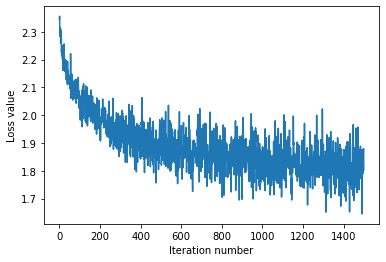

In [10]:
# Implement softmax.train() by filling in the code to extract a batch of data
# and perform the gradient step.
import time


tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Evaluate the performance of the trained softmax classifier on the validation data.

In [11]:
## Implement softmax.predict() and use it to compute the training and testing error.

y_train_pred = softmax.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

training accuracy: 0.3806938775510204
validation accuracy: 0.391


## Optimize the softmax classifier

You may copy and paste your optimization code from the SVM here.

In [12]:
np.finfo(float).eps

2.220446049250313e-16

In [13]:
# ================================================================ #
# YOUR CODE HERE:
#   Train the Softmax classifier with different learning rates and 
#     evaluate on the validation data.
#   Report:
#     - The best learning rate of the ones you tested.  
#     - The best validation accuracy corresponding to the best validation error.
#
#   Select the SVM that achieved the best validation error and report
#     its error rate on the test set.
# ================================================================ #
# lrs = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
lrs = []
y_val_accs = []

for lr in range(10):
    lr = 0.01*10**(-lr)
    lrs.append(lr)
    model = Softmax(dims=[num_classes, num_features])
    model.train(X_train, y_train, learning_rate=lr, num_iters=1500, verbose=False)
    y_pred = model.predict(X_val)
    accuracy = 1 - np.count_nonzero(y_val - y_pred) / y_val.shape[0]
    y_val_accs.append(accuracy)
    print("learning rate = ", lr, "; Accuracy = ", accuracy)

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


learning rate =  0.01 ; Accuracy =  0.08699999999999997
learning rate =  0.001 ; Accuracy =  0.08699999999999997
learning rate =  0.0001 ; Accuracy =  0.30400000000000005
learning rate =  1e-05 ; Accuracy =  0.31799999999999995
learning rate =  1.0000000000000002e-06 ; Accuracy =  0.41800000000000004
learning rate =  1.0000000000000001e-07 ; Accuracy =  0.391
learning rate =  1e-08 ; Accuracy =  0.29600000000000004
learning rate =  1e-09 ; Accuracy =  0.129
learning rate =  1e-10 ; Accuracy =  0.09699999999999998
learning rate =  1.0000000000000001e-11 ; Accuracy =  0.137


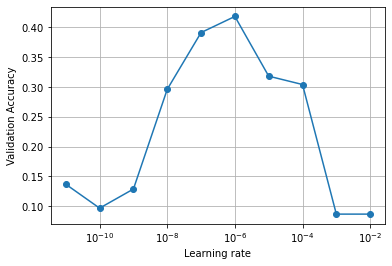

In [14]:
plt.plot(lrs, y_val_accs, marker='o')
plt.xscale("log")
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Validation Accuracy")
plt.show()

In [15]:
lr = 1e-6
losses = model.train(X_train, y_train, learning_rate=lr, num_iters=1500, verbose=False)
y_test_pred = model.predict(X_test)
accuracy = 1 - np.count_nonzero(y_test - y_test_pred) / y_test.shape[0]
print("learning rate = ", lr, "; Accuracy = ", accuracy)

learning rate =  1e-06 ; Accuracy =  0.401


The best learning rate reported is $10^{-6}$ with testing accuracy 0.401